In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
from statsmodels.formula.api import ols #more advanced than scikit-learn
from statsmodels.tsa.stattools import adfuller #?
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score #haven't implemented the r2_score yet
from sklearn.linear_model import LinearRegression #haven't implemented yet
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split #haven't implemented yet
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from math import sqrt
import seaborn as sns
import pandas_datareader.data as reader
import math
import matplotlib.pyplot as plt

Symbols,VIVAX
Date,
2010-10-31,0.019875
2010-11-30,-0.005641
2010-12-31,0.078913
2011-01-31,0.028379
2011-02-28,0.040224
...,...
2020-06-30,-0.009954
2020-07-31,0.035980
2020-08-31,0.042421


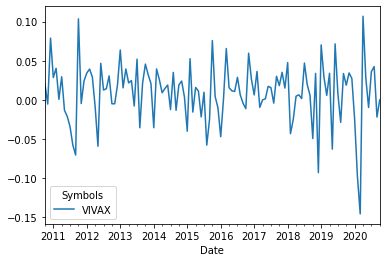

In [2]:
end = dt.date(2020,10,1)
start = dt.date(end.year - 10 , end.month, end.day)
#portfolio = 'SIZE' #SMART BETA FUND, Globalex ETF FACTOR FUND (MIN_VOLITILITY,MOM,VALUE)
portfolio = 'VIVAX' #Vanguard Value index 
fund = [portfolio]
fund_returns = reader.get_data_yahoo(fund,start,end)['Adj Close'].pct_change()
fund_returns_mt= fund_returns.resample('M').agg(lambda x:(x+1).prod()-1)
#fund_returns_mt = fund_returns_mt[:-1] #have an error message in next chunk when this is not commented out 
fund_returns_mt.plot()

fund_returns_mt

In [3]:
factors = reader.DataReader('F-F_Research_Data_Factors','famafrench',start,end)
factors = factors[0]

In [4]:
fund_returns_mt.index = factors.index


full_dataset = pd.merge(fund_returns_mt,factors,on='Date')
full_dataset[['Mkt-RF','SMB','HML','RF']]= full_dataset[['Mkt-RF','SMB','HML','RF']]/100 #coverting from percent to raw value 
full_dataset[portfolio +' - RF']=full_dataset[portfolio] - full_dataset['RF'] #Excess Return = Portfolio - RF
full_dataset=full_dataset.rename(columns = {portfolio :portfolio + ' Raw Returns'})
full_dataset
train = (len(full_dataset)*.8)
train = math.floor(train)
train_data = full_dataset.iloc[0:train, :]
test_data = full_dataset.iloc[train:, :]
train_data.head()

,VIVAX Raw Returns,Mkt-RF,SMB,HML,RF,VIVAX - RF
Date,,,,,,
2010-10,0.019875,0.0388,0.0107,-0.0246,0.0001,0.019775
2010-11,-0.005641,0.0060,0.0378,-0.0095,0.0001,-0.005741
2010-12,0.078913,0.0682,0.0068,0.0364,0.0001,0.078813
2011-01,0.028379,0.0199,-0.0252,0.0082,0.0001,0.028279
2011-02,0.040224,0.0349,0.0153,0.0129,0.0001,0.040124


       VIVAX Raw Returns      Mkt-RF
count         121.000000  121.000000
mean            0.009066    0.010921
std             0.038129    0.040032
min            -0.146404   -0.133800
25%            -0.009329   -0.008500
50%             0.014323    0.012900
75%             0.030498    0.034000
max             0.106927    0.136500
AxesSubplot(0.125,0.125;0.775x0.755)


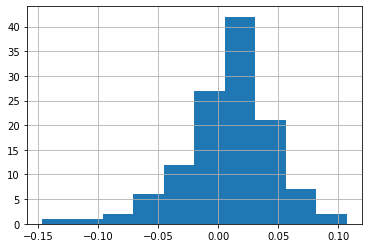

In [5]:
print(full_dataset[[portfolio + ' Raw Returns','Mkt-RF']].describe())
print(full_dataset[portfolio + ' Raw Returns'].hist())
KS_Test = sm.stats.diagnostic.kstest_normal(full_dataset[portfolio + ' Raw Returns'],dist= 'norm')

In [6]:
x_train = train_data[['Mkt-RF','SMB','HML']]
y_train = train_data['VIVAX - RF']
x_test = test_data[['Mkt-RF','SMB','HML']]
y_test = test_data['VIVAX - RF']
x = sm.add_constant(x_train) #add's a non-zero alpha into regression
x_t = sm.add_constant(x_test) #add's a non-zero alpha into regression

                            OLS Regression Results                            
Dep. Variable:             VIVAX - RF   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1003.
Date:                Mon, 19 Apr 2021   Prob (F-statistic):           4.01e-70
Time:                        15:07:20   Log-Likelihood:                 366.04
No. Observations:                  96   AIC:                            -724.1
Df Residuals:                      92   BIC:                            -713.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.167      0.8

/Users/Jordan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


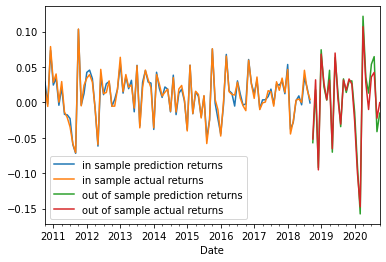

In [7]:
#Modeling & Plotting Results
model = sm.OLS(y_train,x)
results = model.fit()
print(results.summary())
results.params 
results.rsquared
y_hat_train = results.predict(x) #in sample prediction
y_hat_test = results.predict(x_t) #out of sample prediction
y_hat_train.plot(label = 'in sample prediction returns') #green, in-sample prediction 
y_train.plot(label = 'in sample actual returns ') #yellow, in-sample actual excess
y_hat_test.plot(label = 'out of sample prediction returns') #blue, out of sample prediciton
y_test.plot(label = 'out of sample actual returns') # red, out of sample actual excess
ax = plt.subplot()
#ax.plot(y_hat_train, label = "In-Sample Prediction")
#ax.plot(y_hat_test, label = "Out-of-Sample Prediction")
#ax.plot(y_train, label = 'In-Sample Actual')
#ax.plot(y_test, label = 'Out-of-Sample Actual')
ax.legend()

In [8]:
#table = sm.stats.anova_lm(results, typ = 2)

The in-sample MSE is 1.5689584321391922e-37


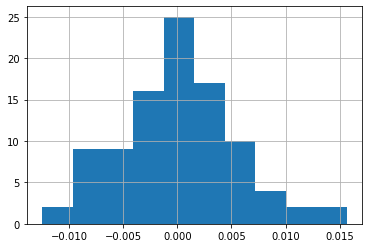

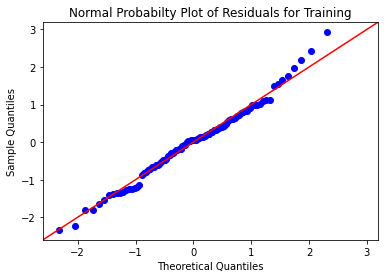

0.005343606661266841
0.011473482872135694


In [9]:
# Residuals/Epsilon Analysis
train_residuals = y_train - y_hat_train #residual in sample
test_residuals =  y_test - y_hat_test #residuals out of sample  
train_MSE = ((train_residuals.mean())**2)**1/2
print("The in-sample MSE is " +str(train_MSE))
train_residuals.hist() #in-sample residual/noise aka unpredicted deviation (histogram)
pplot = sm.ProbPlot(train_residuals,fit = True) #normal prob plot in-sample
fig = pplot.qqplot(line = '45')
plt.title("Normal Probabilty Plot of Residuals for Training")
plt.show()

rmse_train = sqrt(mean_squared_error(y_train, y_hat_train))
rmse_test = sqrt(mean_squared_error(y_test, y_hat_test))

print(rmse_train) #~0.0054
print(rmse_test) #~0.0121



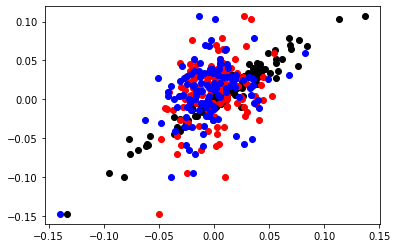

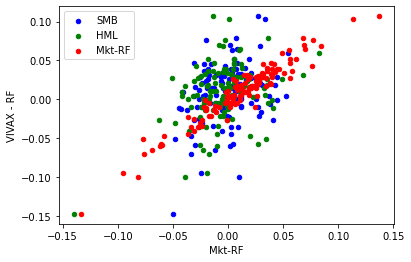

In [10]:
#sns.regplot(full_dataset['SIZE - RF'],
           # full_dataset['HML'],full_dataset['SMB'],)

#plt.scatter,full_dataset['HML'])


x_HML = full_dataset['HML']
x_SMB = full_dataset['SMB']
x_Mkt_RF = full_dataset['Mkt-RF']
y_port = full_dataset['VIVAX - RF']
x1=np.array(x_Mkt_RF)
x2=np.array(x_SMB)
x3=np.array(x_HML)
Y=y_port
X = np.array([x1,x2,x3])

#establising y intercept
#m1, b1 = np.polyfit(x1, Y, 1)
#m2, b2 = np.polyfit(x2, Y, 1)
#m3, b3 = np.polyfit(x3, Y, 1)
#print(b1,m1)
#print(b2,m2)
#print(b3,m3)

'''''
regression_line_x1 = []
for x in x1:
    regression_line_x1.append((m1*x1)+b1)

regression_line_x2 = []
for x in x2:
    regression_line_x2.append((m1*x2)+b2)

regression_line_x3 = []
for x in x3:
    regression_line_x3.append((m1*x3)+b3)
    
'''''

fig =plt.figure()
ax =plt.axes()
plt.scatter(x1,Y,color=['black'], label = 'Mkt-RF',) #Mkt-RF
plt.scatter(x2,Y,color=['red'], label = 'SMB') #SMB
plt.scatter(x3,Y,color=['blue'], label = 'HML') #HML

#respective trend lines
#plt.plot(x1, m1*x1 + b1, color = 'Blue') 
#plt.plot(x2, m2*x2 + b2, color = 'Green')
#plt.plot(x3, m3*x3 + b3, color = 'Red')

#don't know what this means but regression line is all over the place 
#plt.plot(x1,x2,x3, (m1*x1 + b1) + (m2*x2 + b2) + (m3*x3 + b3), color = 'Yellow')  #doesn't accoun for covariance


plt.show()


'''''
for some reason its plotting numerous horizontal lines...
#plt.plot(x1,regression_line_x1)
#plt.plot(x2,regression_line_x2)
#plt.plot(x3,regression_line_x3)
'''''


#scatterplot for SMB and SIZE 
ax1=full_dataset.plot(kind='scatter',x='SMB',y='VIVAX - RF',
                  color='Blue', label = 'SMB')

#scatterplot adding HML
ax1= full_dataset.plot(kind='scatter',x='HML',y='VIVAX - RF',
                  color='Green', label = 'HML', ax = ax1)

#scatterplot for SMB and SIZE 


ax2= full_dataset.plot(kind='scatter',x='Mkt-RF',y='VIVAX - RF',
                  color='Red', label = 'Mkt-RF', ax = ax1)


#want to grup by clusters by decade 


In [11]:
'''''
#fitting curve
def func(x, a, b): #a and b are parameters found using optimizer
    return a*np.exp(b*x)
    #return  a*x+b

plt.plot(x1, y, 'bo', label = "linear")

popt, pcov = curve_fit(func, x1, y) #function fitting data 
print(popt)

plt.plot(x1, func(x1, *popt), 'r', label = 'fit')
'''''


'\'\'\n#fitting curve\ndef func(x, a, b): #a and b are parameters found using optimizer\n    return a*np.exp(b*x)\n    #return  a*x+b\n\nplt.plot(x1, y, \'bo\', label = "linear")\n\npopt, pcov = curve_fit(func, x1, y) #function fitting data \nprint(popt)\n\nplt.plot(x1, func(x1, *popt), \'r\', label = \'fit\')\n'

In [12]:
full_dataset.columns

Index(['VIVAX Raw Returns', 'Mkt-RF', 'SMB', 'HML', 'RF', 'VIVAX - RF'], dtype='object')

ADF Statistic: -11.699357
P Value: 0.000000
Critical Values:
	1%: -3.486
	5%: -2.886
	10%: -2.580


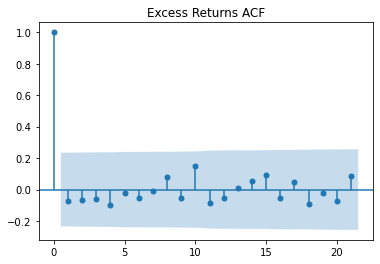

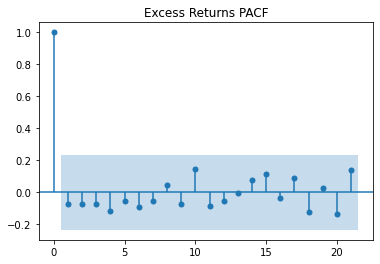

In [13]:
#autocorrelation
sm.graphics.tsa.plot_acf(full_dataset['VIVAX - RF'],alpha = .01, title = 'Excess Returns ACF')
sm.graphics.tsa.plot_pacf(full_dataset['VIVAX - RF'],alpha = .01, title = 'Excess Returns PACF')
result_ADF = adfuller((full_dataset['VIVAX - RF']))
print('ADF Statistic: %f' % result_ADF[0])
print('P Value: %f' % result_ADF[1])
print('Critical Values:')
for key, value in result_ADF[4].items():
    print('\t%s: %.3f' % (key,value))

In [14]:
#10x10 correlation matrix 

#rs = np.random.RandomState(0)
#df = pd.DataFrame(rs.rand(6,6))
corr = full_dataset.corr()
corr.style.background_gradient(cmap='coolwarm')

,VIVAX Raw Returns,Mkt-RF,SMB,HML,RF,VIVAX - RF
VIVAX Raw Returns,1.000000,0.962378,0.290540,0.385260,-0.117846,0.999853
Mkt-RF,0.962378,1.000000,0.349944,0.206914,-0.120647,0.962361
SMB,0.290540,0.349944,1.000000,0.167542,-0.127667,0.292108
HML,0.385260,0.206914,0.167542,1.000000,-0.159985,0.387178
RF,-0.117846,-0.120647,-0.127667,-0.159985,1.000000,-0.134826
VIVAX - RF,0.999853,0.962361,0.292108,0.387178,-0.134826,1.000000


[[0.00158929 0.00031771 0.00021881 0.00145996]
 [0.00031771 0.00051864 0.00010121 0.00025315]
 [0.00021881 0.00010121 0.00070361 0.00039082]
 [0.00145996 0.00025315 0.00039082 0.00144812]]


<AxesSubplot:>

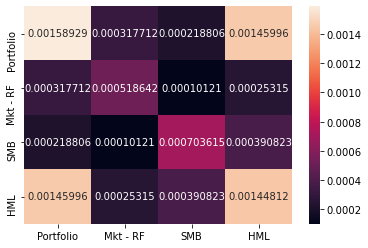

In [15]:
#covariance matrix (transposed where each columns is a variable and each row are observations)

#bias=true allows you to calculate population covariance (not normalized)

#creating covariance as a defined variable 
cov_matrix = np.cov(X, Y, bias=True)
print(cov_matrix)

#covariance heatmap
labels = ['Portfolio', 'Mkt - RF', 'SMB', 'HML']
sns.heatmap(cov_matrix, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)



In [16]:
#quicker way to run regression but need to reshape arrays into 2 dimentional to make it work

regress = linear_model.LinearRegression()
regress_x1 = regress.fit(x1.reshape(-1,1),Y)
regress_x2 = regress.fit(x2.reshape(-1,1),Y)
regress_x3 = regress.fit(x3.reshape(-1,1),Y) #outputs a 80% r correlation 

regress.coef_



array([0.55545077])

In [26]:
full_dataset.columns

Index(['VIVAX Raw Returns', 'Mkt-RF', 'SMB', 'HML', 'RF', 'VIVAX - RF'], dtype='object')

In [27]:
full_dataset.head()

,VIVAX Raw Returns,Mkt-RF,SMB,HML,RF,VIVAX - RF
Date,,,,,,
2010-10,0.019875,0.0388,0.0107,-0.0246,0.0001,0.019775
2010-11,-0.005641,0.0060,0.0378,-0.0095,0.0001,-0.005741
2010-12,0.078913,0.0682,0.0068,0.0364,0.0001,0.078813
2011-01,0.028379,0.0199,-0.0252,0.0082,0.0001,0.028279
2011-02,0.040224,0.0349,0.0153,0.0129,0.0001,0.040124


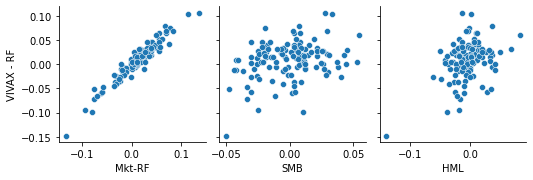

In [33]:
#sns.scatterplot(data=full_dataset,x='SMB', y='VIVAX Raw Returns')
sns.pairplot(data=full_dataset,
            y_vars=['VIVAX - RF'],
            x_vars=['Mkt-RF','SMB','HML'])
plt.show()